# Đề tài: Exploratory Data Analysis of Cryptocurrency Historical Data

Sinh viên thực hiện:

- Lê Thanh Hiếu - 1712434

- Phạm Minh Thắng - 1712759  

Link colab: https://colab.research.google.com/drive/1TB8TWzztma41wrzVkWFVsbnkxZZkHKzd?usp=sharing

## Motivation

Song song với sự phát triển của công nghệ, thị trường tiền điện tử đang có những bước phát triển vô cùng mạnh mẽ. Bên cạnh đó, với tình hình dịch bệnh diễn biến phức tạp trên toàn cầu, các nhà đầu tư trên thế giới ngày càng thể hiện sự quan tâm vào tiềm năng to lớn của tiền điện tử.

Trong bối cảnh đó, đặc biệt với sự kiện đồng BTC đã chạm mốc 20000$ và ngày càng có chiều hướng gia tăng về giá trị, nhóm thực hiện đề tài phân tích và khám phá dữ liệu về một số loại tiền điện tử.

Thông qua phân tích dữ liệu, nhóm mong muốn có được sự hiểu biết cơ bản về các xu hướng và tạo cơ sở cho việc triển khai mô hình dự đoán. Mục tiêu là trả lời một số câu hỏi từ dữ liệu thu thập được như:
1. Đồng tiền nào có giá trị/giá trị thị trường lớn nhất?
2. Tương quan giá top 10 đồng tiền ảo
3. Xu hướng về khối lượng giao dịch cho top các đồng tiền ảo
4. Xem xét về thị phần phân chia giữa top 10 đồng tiền ảo hàng đầu
5. Tương quan giữa các thuộc tính với mỗi đòng tiền
6. Đồng tiền nào dễ biến động hơn và đồng nào ổn định hơn?
7. Biến động giá cả của các loại tiền ảo tương quan với nhau như thế nào?
8. Xu hướng theo mùa (seasonal trend) trong biến động giá trông như thế nào?
9. Dự đoán giá bitcoin trong tương lai. (Áp dụng học máy)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/University/KHDLUD/Labs/Final/Final")

In [ ]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from bokeh.plotting import figure, show, output_file
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
%matplotlib inline

from numpy.linalg import LinAlgError
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Crawling

### Cài đặt các công cụ cần thiết

Cài đặt Selenium và Chromedriver phục vụ cho việc thu thập dữ liệu

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)

### Thu thập dữ liệu

Toàn bộ dữ liệu được thu thập từ trang [Coinmarketcap](https://coinmarketcap.com). 

Về [Coinmarketcap](https://coinmarketcap.com), đây là trang web theo dõi giá tiền điện tử được tham khảo nhiều nhất trên thế giới, trong thời đại mà tiền điện tử ngày càng phát triển nhanh chóng. [Coinmarketcap](https://coinmarketcap.com) cung cấp thông tin chính xác, hiệu quả và trực quan về tiền điện tử cho người sử dụng.

Trang chủ của [Coinmarketcap](https://coinmarketcap.com) hiển thị danh sách các loại tiền điện tử hiện có trên thị trường, được sắp xếp theo giá trị vốn hoá thị trường. Nhóm tiến hành crawl dữ liệu danh sách các đồng tiền trước tiên.

Việc thu thập dữ liệu được thực hiện bằng cách parse HTML với thư viện Selenium (do trang web có sử dụng JavaScript với cơ chế lazy loading).

Các thông tin thu thập được từ danh sách bao gồm:

 - Tên đầy đủ của coin.
 - Ký hiệu của coin.
 - Giá trị của coin tại thời điểm thu thập dữ liệu.
 - Sự thay đổi giá so với 24 giờ/7 ngày trước.
 - Giá trị vốn hoá thị trường (USD).
 - Khối lượng giao dịch trong vòng 24h (theo USD và theo loại coin tương ứng).
 - Tổng lượng coin đang được lưu thông trên thị trường.
 - URL dẫn đến trang cung cấp thông tin chi tiết từng loại coin.


In [ ]:
%%script false
home_url = "https://coinmarketcap.com"
driver.get(home_url)

In [ ]:
%%script false
driver.find_element_by_class_name("hKnmWV").click()
driver.find_element_by_class_name("jvQpLZ").find_element_by_xpath("button[3]").click()
driver.find_element_by_class_name("cmc-cookie-policy-banner__close").click()
driver.find_element_by_tag_name("html").send_keys(Keys.END)

In [ ]:
%%script false
coin_file = open("coin_list.csv", "w+")
coin_file.write("name\tsymbol\tprice\t24h\t7d\tmarket_cap\tvolume(usd)\tvolume(coin)\tcirculating_supply\turl\n")

In [ ]:
%%script false
while True:
    print("Page:", driver.find_element_by_class_name("rc-pagination-item-active").get_attribute("title"))
    lines = driver.find_element_by_class_name("tableWrapper___3utdq").find_element_by_tag_name("tbody").find_elements_by_tag_name("tr")
    for line in lines:
        try:
            content = line.text.replace("\n", "\t")
            link = line.find_element_by_tag_name("a").get_attribute("href") + "historical-data/?start=20100101&end=20201215"
            coin_file.write(f"{content}\t{link}\n")
        except:
            pass

    next = driver.find_element_by_class_name("eEiCJF").find_element_by_class_name("rc-pagination-next")
    if "rc-pagination-disabled" not in next.get_attribute("class"):
        next.click()
        time.sleep(1)
    else:
        break

coin_file.close()

Sau khi đã có được danh sách các đồng tiền điện tử, nhóm tiến hành thu thập lịch sử thay đổi giá của các đồng tiền trên. Để thu thập lịch sử giá từng loại coin, nhóm sử dụng URL được thu thập trong danh sách các loại coin. Lịch sử được thu thập từ ngày đầu tiên coin có mặt trên thị trường đến ngày 16/12/2020.

In [ ]:
coin_list = pd.read_csv("coin_list.csv", sep="\t")

In [ ]:
coin_list.dropna(subset=["url"], inplace=True)
coin_list.drop_duplicates(subset=["name", "symbol"],inplace=True)
coin_list.index = coin_list.index.astype(int)

In [ ]:
coin_list

,name,symbol,price,24h,7d,market_cap,volume(usd),volume(coin),circulating_supply,url
1,Bitcoin,BTC,"$26,726.84",3.61%,17.11%,"$497,741,034,997","$63,368,452,500","2,365,883 BTC","18,583,331 BTC",https://coinmarketcap.com/currencies/bitcoin/h...
2,Ethereum,ETH,$727.18,12.94%,18.28%,"$83,066,027,790","$33,108,494,005","45,444,903 ETH","114,016,892 ETH",https://coinmarketcap.com/currencies/ethereum/...
3,Tether,USDT,$0.998099,0.03%,0.06%,"$20,781,363,466","$98,199,951,695","98,386,620,807 USDT","20,820,866,934 USDT",https://coinmarketcap.com/currencies/tether/hi...
4,XRP,XRP,$0.296772,2.27%,44.09%,"$13,453,037,560","$9,457,140,954","31,917,869,612 XRP","45,404,028,640 XRP",https://coinmarketcap.com/currencies/xrp/histo...
5,Litecoin,LTC,$134.63,0.99%,27.06%,"$8,993,704,276","$13,904,633,547","102,328,515 LTC","66,187,462 LTC",https://coinmarketcap.com/currencies/litecoin/...
...,...,...,...,...,...,...,...,...,...,...
4090,WELL,WELL,$0.302254,3.31%,12.78%,$0,$0,0 WELL,0 WELL,https://coinmarketcap.com/currencies/well-toke...
4096,Alpha5,A5T,$0.666347,0.07%,1.57%,$0,$0,0 A5T,0 A5T,https://coinmarketcap.com/currencies/alpha5/hi...
4097,Sugarchain,SUGAR,$0.003149,1.71%,0.82%,$0,$0,0 SUGAR,0 SUGAR,https://coinmarketcap.com/currencies/sugarchai...
4111,Decentralized Bank,DEBA,$0.026548,13.92%,2.24%,$0,$0,0 DEBA,0 DEBA,https://coinmarketcap.com/currencies/decentral...


In [ ]:
%%script false
for i in range(len(coin_list)):
    coin = coin_list.iloc[i]
    symbol = coin["symbol"]
    f = open(f"data/{symbol}.csv", "w+")
    f.write("date\topen\thigh\tlow\tclose\tvolume\tmarket_cap\n")

    url = coin["url"]
    driver.get(url)

    time.sleep(10)

    try:
        data_table = driver.find_element_by_tag_name("tbody")
    except:
        continue

    content = data_table.text.split("\n")
    count = 0
    for value in content:
        f.write(value)
        count += 1
        if count < 7:
            f.write("\t")
        else:
            f.write("\n")
            count = 0
    f.close()
        

## Understanding the Data




Dưới đây là danh sách các loại coin được thu thập ở phần đầu tiên. Danh sách này được sắp xếp theo thứ tự giảm dần của giá trị vốn hoá

In [ ]:
coin_list

,name,symbol,price,24h,7d,market_cap,volume(usd),volume(coin),circulating_supply,url
1,Bitcoin,BTC,"$26,726.84",3.61%,17.11%,"$497,741,034,997","$63,368,452,500","2,365,883 BTC","18,583,331 BTC",https://coinmarketcap.com/currencies/bitcoin/h...
2,Ethereum,ETH,$727.18,12.94%,18.28%,"$83,066,027,790","$33,108,494,005","45,444,903 ETH","114,016,892 ETH",https://coinmarketcap.com/currencies/ethereum/...
3,Tether,USDT,$0.998099,0.03%,0.06%,"$20,781,363,466","$98,199,951,695","98,386,620,807 USDT","20,820,866,934 USDT",https://coinmarketcap.com/currencies/tether/hi...
4,XRP,XRP,$0.296772,2.27%,44.09%,"$13,453,037,560","$9,457,140,954","31,917,869,612 XRP","45,404,028,640 XRP",https://coinmarketcap.com/currencies/xrp/histo...
5,Litecoin,LTC,$134.63,0.99%,27.06%,"$8,993,704,276","$13,904,633,547","102,328,515 LTC","66,187,462 LTC",https://coinmarketcap.com/currencies/litecoin/...
...,...,...,...,...,...,...,...,...,...,...
4090,WELL,WELL,$0.302254,3.31%,12.78%,$0,$0,0 WELL,0 WELL,https://coinmarketcap.com/currencies/well-toke...
4096,Alpha5,A5T,$0.666347,0.07%,1.57%,$0,$0,0 A5T,0 A5T,https://coinmarketcap.com/currencies/alpha5/hi...
4097,Sugarchain,SUGAR,$0.003149,1.71%,0.82%,$0,$0,0 SUGAR,0 SUGAR,https://coinmarketcap.com/currencies/sugarchai...
4111,Decentralized Bank,DEBA,$0.026548,13.92%,2.24%,$0,$0,0 DEBA,0 DEBA,https://coinmarketcap.com/currencies/decentral...


In [ ]:
top10 = coin_list.head(10)
print(top10.columns)

Index(['name', 'symbol', 'price', '24h', '7d', 'market_cap', 'volume(usd)',
       'volume(coin)', 'circulating_supply', 'url'],
      dtype='object')


In [ ]:
top10_symbol = top10['symbol']
top10['name']

1          Bitcoin
2         Ethereum
3           Tether
4              XRP
5         Litecoin
6     Bitcoin Cash
7          Cardano
8         Polkadot
9     Binance Coin
10       Chainlink
Name: name, dtype: object

In [ ]:
top10_symbol

1      BTC
2      ETH
3     USDT
4      XRP
5      LTC
6      BCH
7      ADA
8      DOT
9      BNB
10    LINK
Name: symbol, dtype: object

Vì đã thu thập dữ liệu thay đổi giá của từng loại coin, nhóm tiến hành trích xuất dữ liệu từng loại coin vào cùng một dataframe.

In [ ]:
df = pd.DataFrame()
for symbol in coin_list.symbol.values:
    temp_df = pd.read_csv(f"data/{symbol}.csv", parse_dates=["date"], sep='\t', thousands=',')
    temp_df.insert(0,"symbol", symbol)
    df = pd.concat([df, temp_df])
df.reset_index(drop=True,inplace=True)

In [ ]:
df

,symbol,date,open,high,low,close,volume,market_cap
0,BTC,2020-12-16,19418.820000,21458.910000,19298.320000,21310.600000,4.440901e+10,395799863746
1,BTC,2020-12-15,19246.920000,19525.010000,19079.840000,19417.080000,2.674198e+10,360614771027
2,BTC,2020-12-14,19144.490000,19305.100000,19012.710000,19246.640000,2.247400e+10,357432550020
3,BTC,2020-12-13,18806.770000,19381.540000,18734.330000,19142.380000,2.545047e+10,355479173806
4,BTC,2020-12-12,18051.320000,18919.550000,18046.040000,18803.660000,2.175258e+10,349170613899
...,...,...,...,...,...,...,...,...
17303,LINK,2017-09-24,0.131110,0.190250,0.130275,0.170278,1.025740e+06,59597300
17304,LINK,2017-09-23,0.149562,0.157440,0.126297,0.131129,1.186670e+06,45895150
17305,LINK,2017-09-22,0.169826,0.181675,0.139869,0.150503,1.423220e+06,52676050
17306,LINK,2017-09-21,0.189132,0.207892,0.155292,0.169680,2.126270e+06,59388000


In [ ]:
df.head()

,symbol,date,open,high,low,close,volume,market_cap
0,BTC,2020-12-16,19418.82,21458.91,19298.32,21310.60,4.440901e+10,395799863746
1,BTC,2020-12-15,19246.92,19525.01,19079.84,19417.08,2.674198e+10,360614771027
2,BTC,2020-12-14,19144.49,19305.10,19012.71,19246.64,2.247400e+10,357432550020
3,BTC,2020-12-13,18806.77,19381.54,18734.33,19142.38,2.545047e+10,355479173806
4,BTC,2020-12-12,18051.32,18919.55,18046.04,18803.66,2.175258e+10,349170613899


In [ ]:
df.describe()

,open,high,low,close,volume,market_cap
count,17308.000000,17308.000000,17308.000000,17308.000000,1.730800e+04,1.730800e+04
mean,714.992224,734.359434,694.797286,716.213997,3.418179e+09,1.687233e+10
std,2303.123411,2364.485161,2237.989228,2308.415878,8.880574e+09,4.139602e+10
min,0.002809,0.003082,0.002802,0.002810,0.000000e+00,0.000000e+00
25%,0.676505,0.714021,0.636692,0.676463,7.111132e+06,3.212935e+08
50%,5.660000,6.040000,5.355000,5.710000,2.055904e+08,3.138486e+09
75%,225.817500,231.172500,220.470000,225.967500,2.002792e+09,1.031005e+10
max,19633.770000,21458.910000,19298.320000,21310.600000,1.146168e+11,3.957999e+11


### Features
Tập dữ liệu về giá của từng loại coin chứa các thuộc tính sau:
- **Date**: Ngày quan sát dữ liệu
- **Open**: Giá mở cửa của ngày được cho
- **High**: Giá cao nhất trong ngày được cho
- **Low**: Giá thấp nhất trong ngày được cho
- **Close**: Giá đóng cửa của ngày đựơc cho
- **Volume**: Khối lượng giao dịch trong ngày được cho
- **Market Cap**: Vốn hóa thị trường tính bằng USD

## Data Preprocessing

In [ ]:
# summarize the number of unique values in each column
print(df.nunique())

symbol           10
date           2790
open          13010
high          12614
low           13636
close         12958
volume        16662
market_cap    16646
dtype: int64


In [ ]:
df.shape

(17308, 8)

In [ ]:
df.columns

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'volume',
       'market_cap'],
      dtype='object')

## Exploratory Data Analysis

#### Giá trị thị trường

Text(0.5, 1.0, 'Top 10 Currencies by Market Cap')

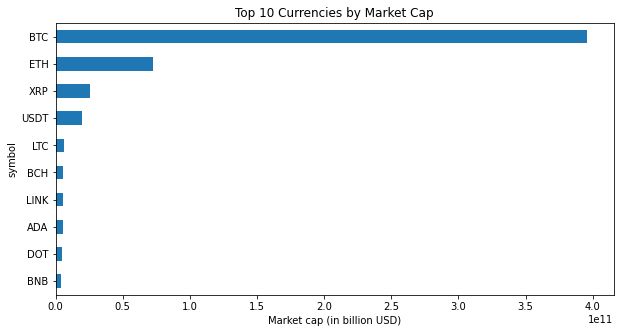

In [ ]:
# Top 10 cryptocurrencies in 2020 Market Cap wise
ax = df.groupby(['symbol'])['market_cap'].first().sort_values(ascending=False).head(10).sort_values().plot(kind='barh', figsize=(10,5))
ax.set_xlabel("Market cap (in billion USD)")
plt.title("Top 10 Currencies by Market Cap")

Text(0.5, 1.0, 'Top 10 Currencies by Price per 1 unit')

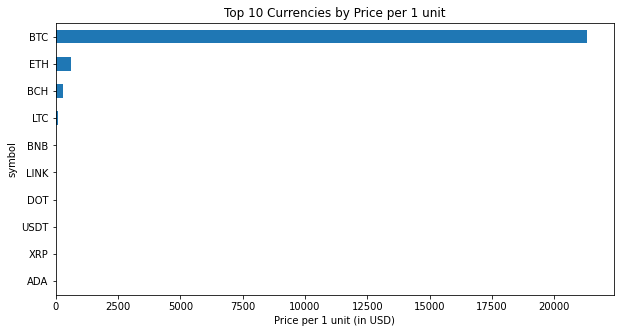

In [ ]:
# Top 10 cryptocurrencies in 2020 Market Cap wise
ax = df.groupby(['symbol'])['close'].first().sort_values(ascending=False).head(10).sort_values().plot(kind='barh', figsize=(10,5))
ax.set_xlabel("Price per 1 unit (in USD)")
plt.title("Top 10 Currencies by Price per 1 unit")

#### Tương quan giá top 10 đồng tiền ảo

In [ ]:
top_10_currency_names = df.groupby(['symbol'])['market_cap'].first().sort_values(ascending=False).head(10).index
top_10_currency_names

Index(['BTC', 'ETH', 'XRP', 'USDT', 'LTC', 'BCH', 'LINK', 'ADA', 'DOT', 'BNB'], dtype='object', name='symbol')

In [ ]:
data_top_10_currencies = df[df['symbol'].isin(top_10_currency_names)]
data_top_10_currencies

,symbol,date,open,high,low,close,volume,market_cap
0,BTC,2020-12-16,19418.820000,21458.910000,19298.320000,21310.600000,4.440901e+10,395799863746
1,BTC,2020-12-15,19246.920000,19525.010000,19079.840000,19417.080000,2.674198e+10,360614771027
2,BTC,2020-12-14,19144.490000,19305.100000,19012.710000,19246.640000,2.247400e+10,357432550020
3,BTC,2020-12-13,18806.770000,19381.540000,18734.330000,19142.380000,2.545047e+10,355479173806
4,BTC,2020-12-12,18051.320000,18919.550000,18046.040000,18803.660000,2.175258e+10,349170613899
...,...,...,...,...,...,...,...,...
17303,LINK,2017-09-24,0.131110,0.190250,0.130275,0.170278,1.025740e+06,59597300
17304,LINK,2017-09-23,0.149562,0.157440,0.126297,0.131129,1.186670e+06,45895150
17305,LINK,2017-09-22,0.169826,0.181675,0.139869,0.150503,1.423220e+06,52676050
17306,LINK,2017-09-21,0.189132,0.207892,0.155292,0.169680,2.126270e+06,59388000


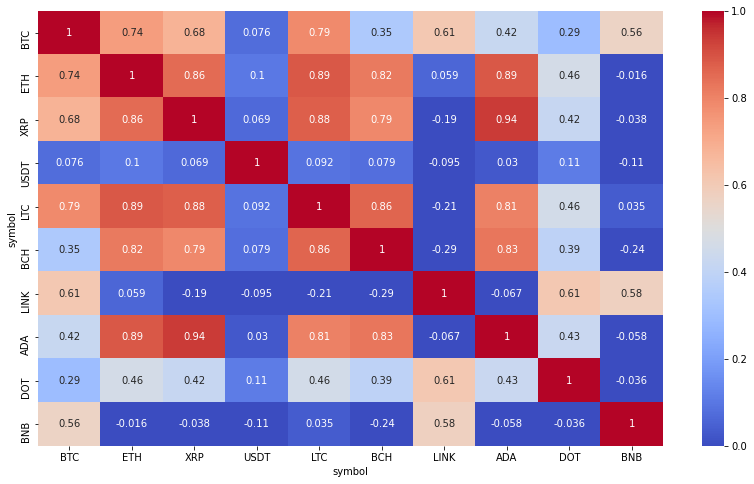

In [ ]:
# dataframe where we will observe closing prices for each currency
close_df = df.groupby(['date', 'symbol'])['close'].last().unstack()
plt.figure(figsize=(14,8))
sns.heatmap(close_df[top_10_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

#### Tương quan về giá trị thị trường top 10 đồng tiền ảo

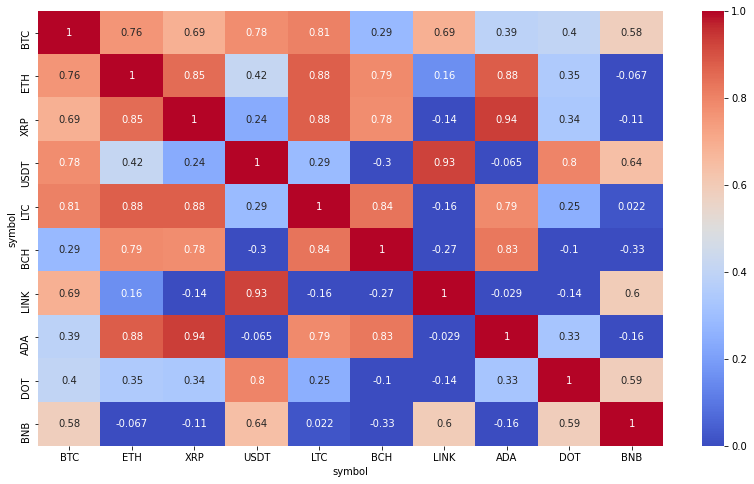

In [ ]:
# dataframe where we will observe market cap for each currency
market_df = df.groupby(['date', 'symbol'])['market_cap'].last().unstack()
plt.figure(figsize=(14,8))
sns.heatmap(market_df[top_10_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

#### Xem xét về thị phần phân chia giữa top 10 đồng tiền ảo hàng đầu (treemap)

#### Giá trị (USD) trên 1 đơn vị theo thời gian

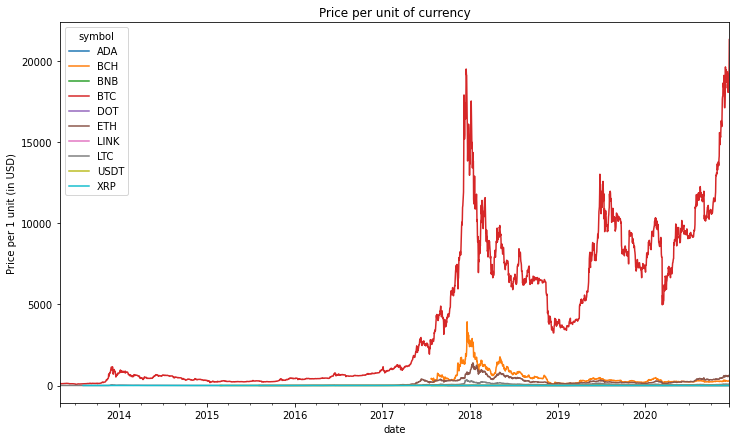

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
ax = data_top_10_currencies.groupby(['date', 'symbol'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency"); 
plt.show()

#### Giá trị thị trường theo thời gian

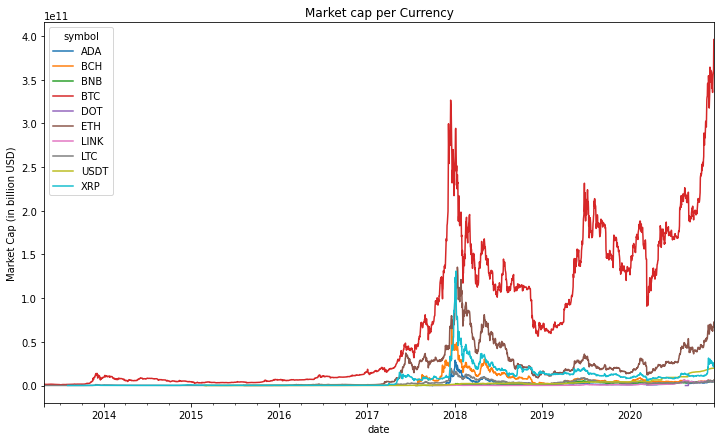

In [ ]:
# Market Capitalization
ax = data_top_10_currencies.groupby(['date', 'symbol'])['market_cap'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency"); 

#### Khối lượng giao dịch theo thời gian

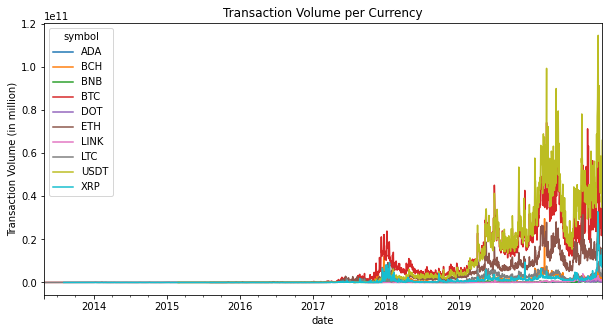

In [ ]:
# Volume
ax = data_top_10_currencies.groupby(['date', 'symbol'])['volume'].mean().unstack().plot(figsize=(10,5));
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency");

#### Giá trị thị trường trên tổng số đơn vị đang lưu hành

##### Khối lượng giao dịch trên tổng số đơn vị đang lưu hành

#### Biểu đồ nến (Candlestick chart) cho Bitcoin

In [ ]:
def increase_decrease(open, close):
  if close > open:
    value = 'Increase'
  elif close < open:
    value = 'Decrease'
  else:
    value = 'Equal'
  return value

In [ ]:
# def draw_candle_chart(df, symbol):
#   df.loc[df['symbol'] == symbol]
  
#   df["status"] = [increase_decrease(o, c) for o, c in zip(df.open, df.close)]
#   df["middle"] = (df.open + df.close)/2
#   df["height"] = abs(df.close-df.open)
#   pic = figure(x_axis_type='datetime', width=1000, height=300)
#   pic.title.text="Candle stick chart for " + symbol
#   print(df.columns)
#   hours_12=12*60*60*1000
#  # Increase
#   pic.rect(df.index[df.status=="Increase"],df.middle[df.status=="Increase"],
#   hours_12, df.height[df.status=="Increase"],fill_color="#CCFFFF",
#   line_color="black")
#   # Decrease
#   pic.rect(df.index[df.status=="Decrease"],df.middle[df.status=="Decrease"],
#   hours_12, df.height[df.status=="Decrease"],fill_color="#FF3333",
#   line_color="black")
#   pic.segment(df.index, df.high, df.index, df.low, color="Black")
#   output_file('bitcoin.html')
#   show(pic)

# draw_candle_chart(df, 'BTC')

In [ ]:
import plotly.graph_objects as go
from datetime import datetime

In [ ]:
def draw_candle_chart(df, symbol):
  df = df.loc[df['symbol'] == symbol]
  fig = go.Figure(data=[go.Candlestick(x=df['date'],
                  open=df['open'],
                  high=df['high'],
                  low=df['low'],
                  close=df['close'])])
  fig.update_layout(xaxis_rangeslider_visible=False)
  fig.show()

draw_candle_chart(df, 'BTC')

#### Biểu đồ nến:
- Thân nến được tô màu biểu trưng cho sự tăng giảm của giá, bóng nến là 2 que nhỏ nằm ở trên và dưới thân nến.
- Hai đỉnh thân nến tương ứng giá đóng cửa, mở cửa của phiên giao dịch. Với nến màu xanh: giá mở cửa ở dưới, giá đóng cửa ở trên và ngược lại.
- Đỉnh trên/dưới bóng nến tương ứng giá cao nhất/thấp nhất trong phiên giao dịch.

##### Ý nghĩa cơ bản:
- Thân nến càng dài chứng tỏ sức mua/bán càng mạnh. Thân nến dài cho thấy chênh lệch lớn giữa giá mở cửa và đóng cửa. Điều này chứng tỏ phe mua đang áp đảo phe bán nếu nến xanh hoặc phe bán đang gây áp lực mạnh nếu nến đỏ.
- Thân nến ngắn cho thấy thị trường đang chững lại, cả 2 phe đều đang lưỡng lự chưa quyết định.
- Bóng nến dài chứng tỏ thị trường đang có sự cạnh tranh giữa 2 phe. Cả 2 phe đều mua bán mạnh khiến giá tăng giảm liên tục. Cần quan tâm đến đỉnh của bóng nến (giá cao nhất/thấp nhất) để đánh giá các mức cản (ngưỡng hỗ trợ, ngưỡng kháng cự).





### Phân tích sâu hơn về Bitcoin

Bitcoin đang được xem như biểu tượng của tiền điện tử, khi mà sự quan tâm về lĩnh vực này được đặt chủ yếu lên Bitcoin. Nhắc đến tiền điện tử thì không thể không nhắc đến Bitcoin. Vì vậy nhóm sẽ tiến hành phân tích tập trung vào đồng Bitcoin trên thị trường.

Việc phân tích và dự đoán giá của đồng Bitcoin được thực hiện trên giá đóng cửa của Bitcoin theo từng ngày.

In [ ]:
btc_df = df[(df["symbol"] == "BTC")]
btc_df.set_index("date", inplace=True)
btc_df.sort_index(inplace=True)
btc_df

,symbol,open,high,low,close,volume,market_cap
date,,,,,,,
2013-04-28,BTC,135.30,135.98,132.10,134.21,0.000000e+00,1488566728
2013-04-29,BTC,134.44,147.49,134.00,144.54,0.000000e+00,1603768865
2013-04-30,BTC,144.00,146.93,134.05,139.00,0.000000e+00,1542813125
2013-05-01,BTC,139.00,139.89,107.72,116.99,0.000000e+00,1298954594
2013-05-02,BTC,116.38,125.60,92.28,105.21,0.000000e+00,1168517495
...,...,...,...,...,...,...,...
2020-12-12,BTC,18051.32,18919.55,18046.04,18803.66,2.175258e+10,349170613899
2020-12-13,BTC,18806.77,19381.54,18734.33,19142.38,2.545047e+10,355479173806
2020-12-14,BTC,19144.49,19305.10,19012.71,19246.64,2.247400e+10,357432550020


Dữ liệu về sự thay đổi giá đồng BTC là dữ liệu time-series.

#### Biểu đồ giá BTC

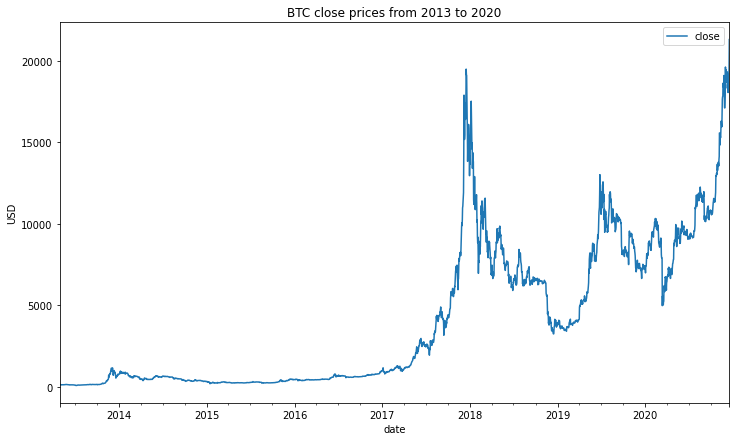

In [ ]:
btc_df[["close"]].plot(title="BTC close prices from 2013 to 2020", ylabel="USD")

#### Kiểm tra tính dừng của dữ liệu

Dữ liệu time-series có tính dừng có ý nghĩa trong việc dự đoán dữ liệu, giúp cho việc mô hình hoá dữ liệu dễ dàng thu được kết quả chính xác hơn. Để kiểm tra tính dừng của dữ liệu, ta sử dụng phương pháp kiểm định Dickey-Fuller và phân rã dữ liệu.

Việc phân rã được thực hiện bằng cách phân rã dữ liệu giá thành các thành phần con:
 - Trend: thành phần này chỉ ra xu hướng tổng quan của dữ liệu theo thời gian: lên hoặc xuống, tăng hoặc giảm
 - Seasonality: thành phần chỉ ra các xu hướng theo mùa vị, chỉ ra các pattern theo tháng, theo quý
 - Error: thành phần nhiễu còn lại sau khi trích xuất hết các thành phần ở trên, nó chỉ ra sự bất thường của các điểm dữ liệu

Sử dụng Addictive Time-Series để phân rã: Value = Base Level + Trend + Seasonality + Error

In [ ]:
def decompose(df):
    # Additive Decomposition
    result_add = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (8,8)})
    result_add.plot().suptitle('Additive Decompose', fontsize=12)
    plt.show()

Sử dụng DF Test sẽ cho chúng ta biết được giá trị P-value của dữ liệu. Nếu P-value nhỏ hơn 0.05, ta có thể xem như dữ liệu có tính dừng.

In [ ]:
def ADFTest(series):
    adf = adfuller(series)
    print("P-value: {}".format(adf[1]))

Trước tiên ta tiến hành kiểm tra với dữ liệu ban đầu.

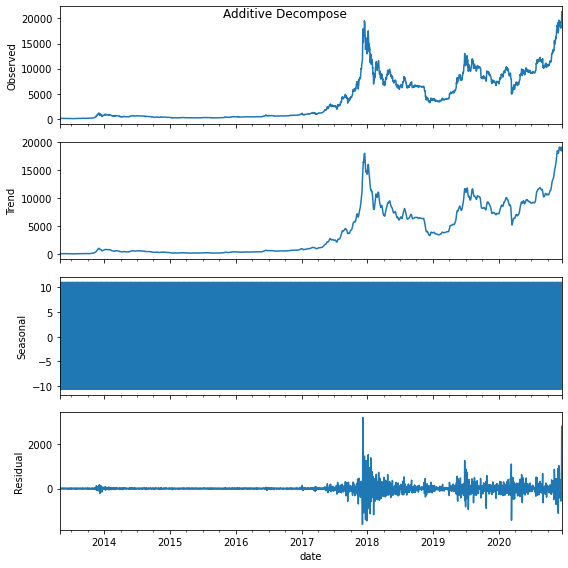

P-value: 0.9781905486162903


In [ ]:
decompose(btc_df.close)
ADFTest(btc_df.close)

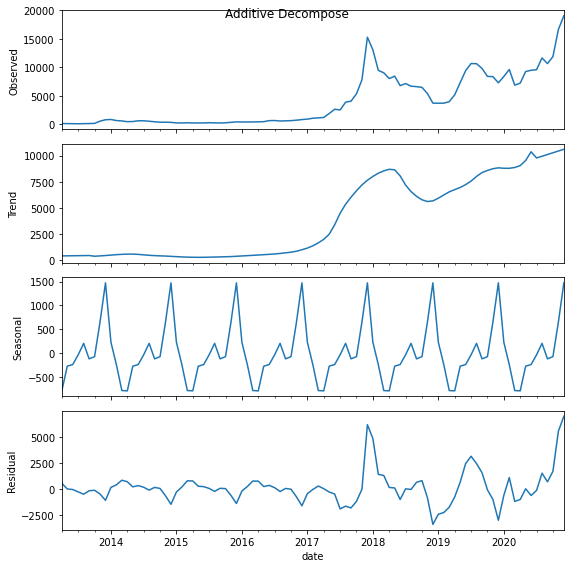

P-value: 0.9705194887946383


In [ ]:
btc_month_df = btc_df.resample('M').mean()

decompose(btc_month_df.close)
ADFTest(btc_month_df.close)

Ta có thể dễ dàng nhận thấy độ lỗi trước 2017 dao động tương đối ổn định, cho đến gần cuối năm 2017, khi mà xảy ra hiện tượng bong bóng tiền ảo, khiến cho giá trị thay đổi có tính bất thường cao.

Với giá trị P-value như trên, ta có thể dễ dàng nhận thấy dữ liệu không có tính dừng. Việc này sẽ khó khăn cho việc mô hình hoá dữ liệu.

Bên cạnh đó, ta có thể thấy khoảng cuối năm 2017 có sự bất thuờng lớn ở dữ liệu. Điều này tương đối rõ ràng khi mà giai đoạn đó là giai đoạn bong bóng tiền điện tử diễn ra với sự đạt đỉnh kỉ lục của giá trị đồng BTC (so với thời điểm trước đó).

Ta thử biến đổi dữ liệu để dữ liệu trở nên dễ dàng hơn cho việc dự đoán.

#### Biến đổi dữ liệu

##### Differencing

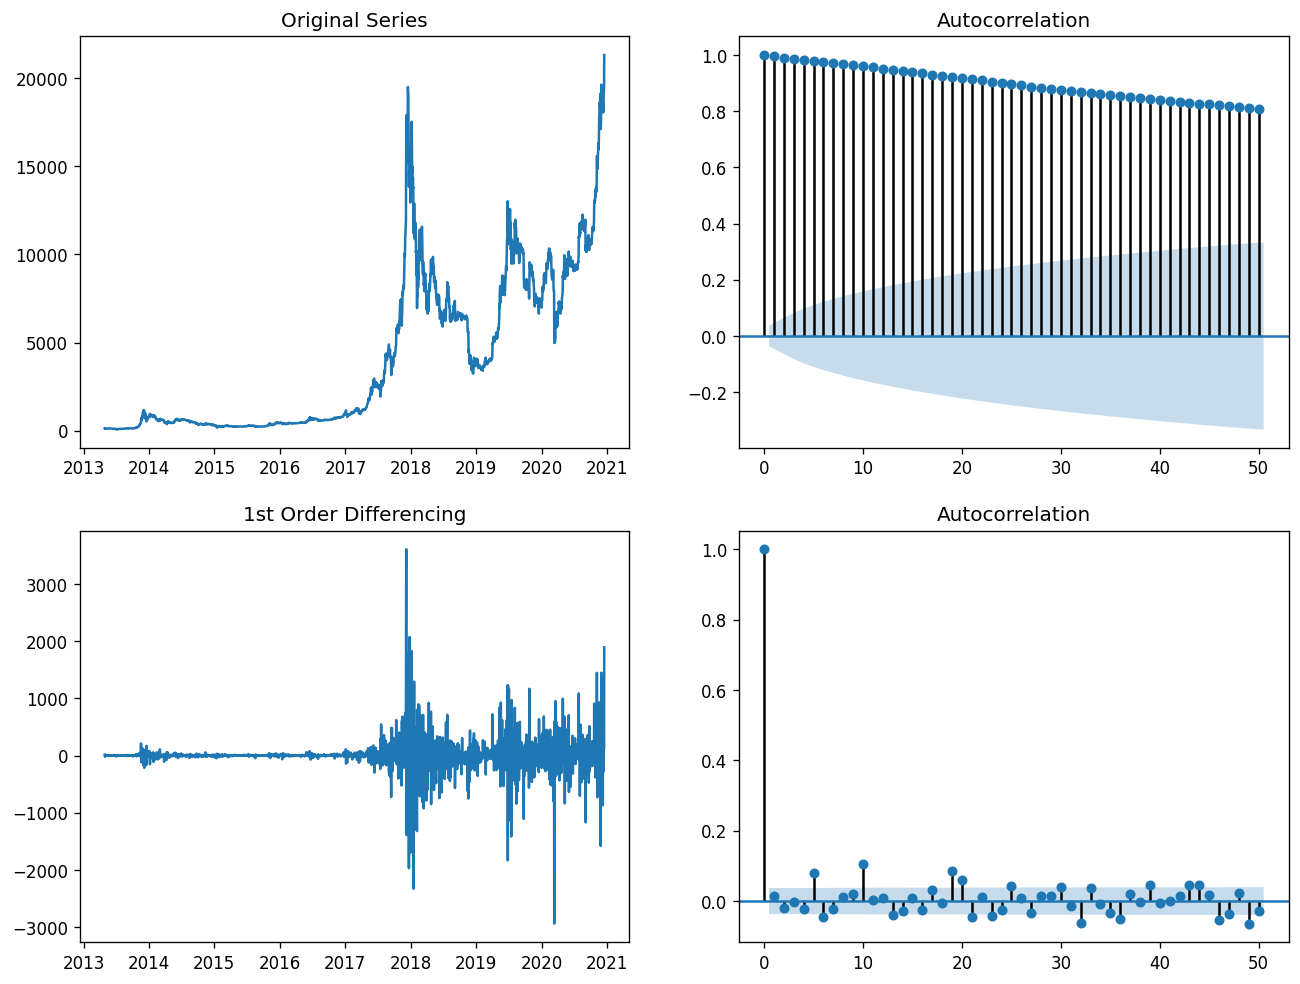

In [ ]:
plt.rcParams.update({'figure.figsize':(13,10), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

# Original Series
axes[0, 0].plot(btc_df.close); axes[0, 0].set_title('Original Series')
plot_acf(btc_df.close, ax=axes[0, 1], lags=50)

# 1st Differencing
axes[1, 0].plot(btc_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(btc_df.close.diff().dropna(), ax=axes[1, 1],lags=50)

plt.show()

In [ ]:
print("On 1st order differencing, ", end="")
ADFTest(btc_df.close.diff().dropna())

On 1st order differencing, P-value: 9.681677825876552e-16


P-value thu được nhỏ hơn 0.05, nghĩa là ta đã thu được dữ liệu có tính dừng.

Dựng biểu đồ ACF và PACF ta được:

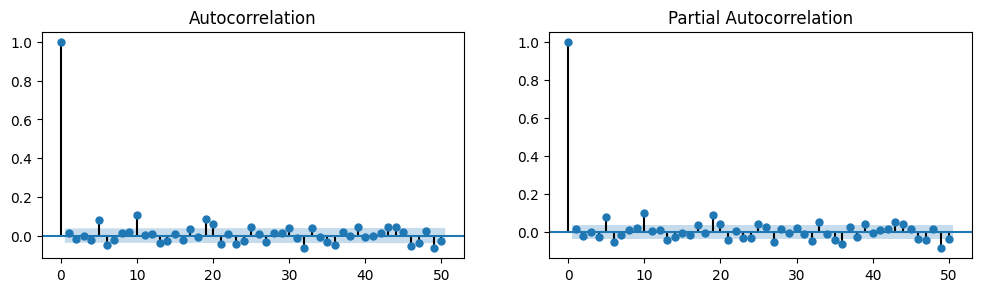

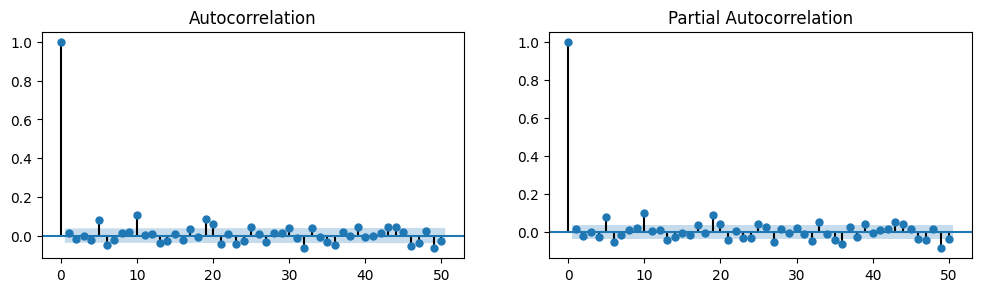

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,3), dpi= 100)
plot_acf(btc_df.close.diff().dropna(), lags=50,ax=axes[0])
plot_pacf(btc_df.close.diff().dropna(), lags=50, ax=axes[1])

##### Biến đổi hàm log và differencing

In [ ]:
btc_log_df = pd.DataFrame(np.log(btc_df.close))
btc_log_diff_df = btc_log_df.diff().dropna()

In [ ]:
print("On log series, ", end="")
ADFTest(btc_log_df.close)
print("On 1st order differencing with log series, ", end="")
ADFTest(btc_log_diff_df.close)

On log series, P-value: 0.7753216824357201
On 1st order differencing with log series, P-value: 4.481009462591097e-19


P-value thu được nhỏ hơn 0.05, như vậy ta đã có thể xem như dữ liệu có tính dừng.

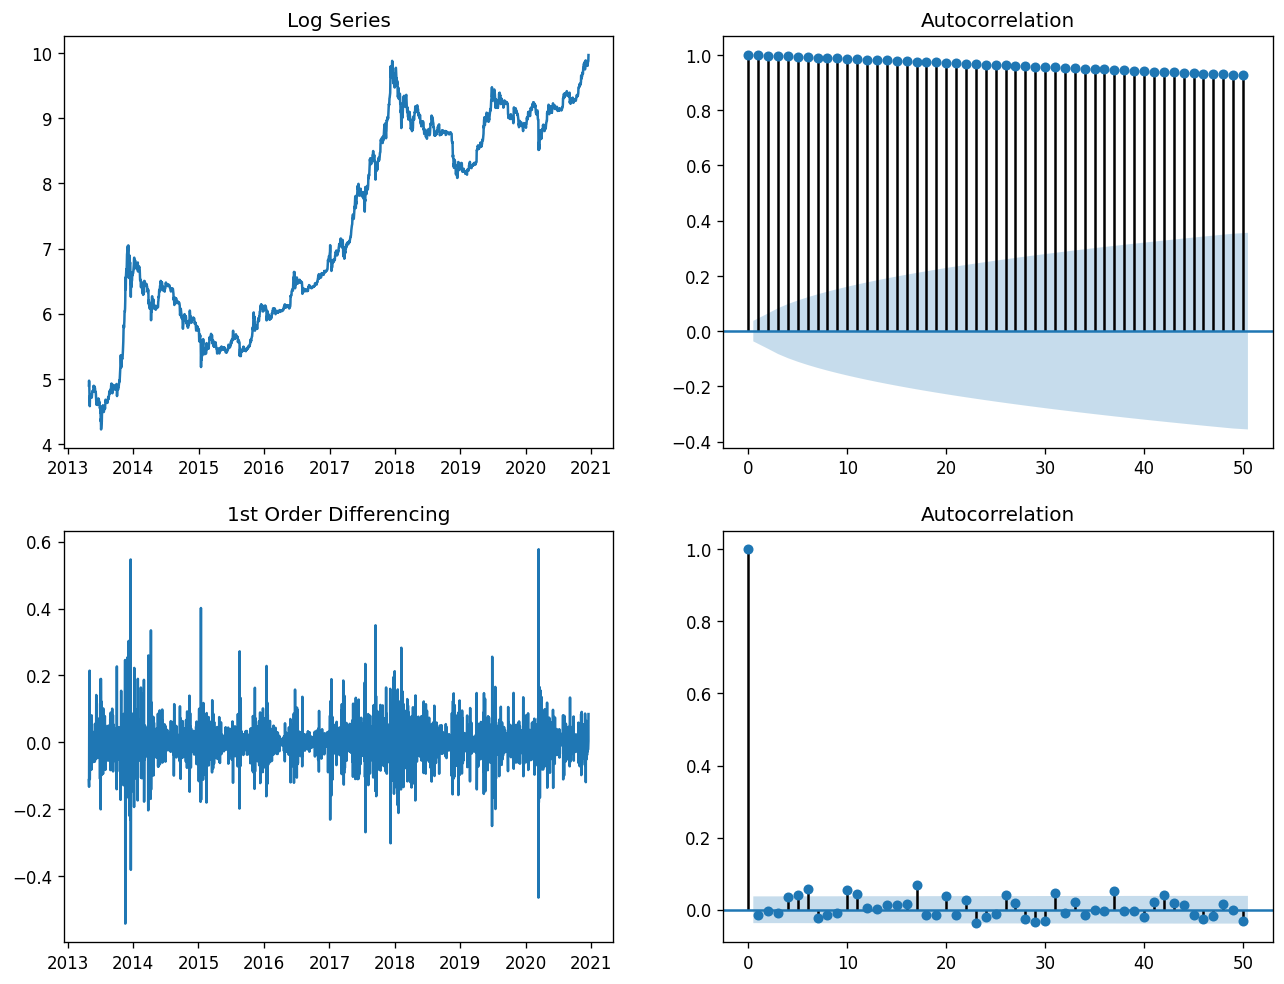

In [ ]:
plt.rcParams.update({'figure.figsize':(13,10), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

# Original Series
axes[0, 0].plot(btc_log_df.close); axes[0, 0].set_title('Log Series')
plot_acf(btc_log_df.close, ax=axes[0, 1], lags=50)

# 1st Differencing
axes[1, 0].plot(btc_log_diff_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(btc_log_diff_df.close, ax=axes[1, 1],lags=50)

plt.show()

Ta lần lượt vẽ biểu đồ ACF và PACF với hai Differencing Series

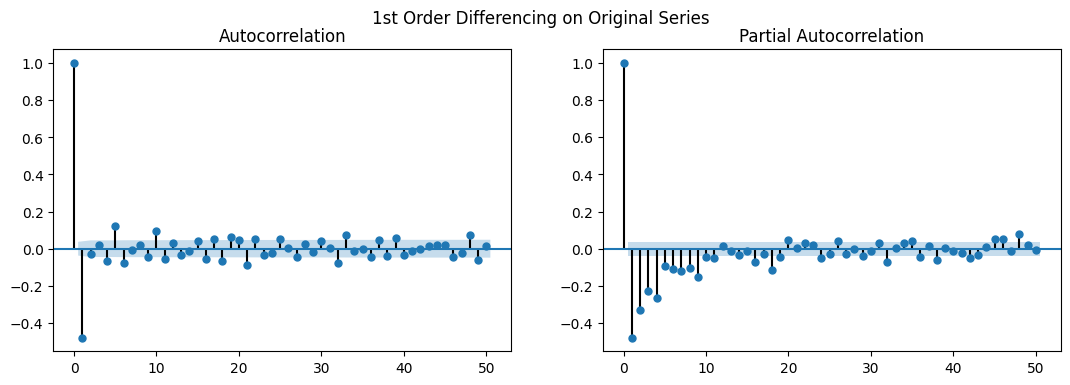

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,4), dpi= 100)
fig.suptitle("1st Order Differencing on Original Series")
plot_acf(btc_df.close.diff().diff().dropna(), lags=50,ax=axes[0])
plot_pacf(btc_df.close.diff().diff().dropna(), lags=50, ax=axes[1])
plt.show()

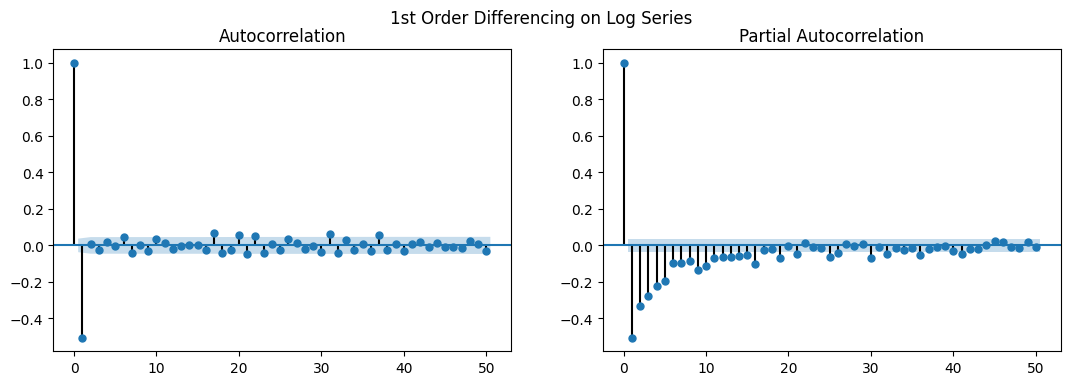

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,4), dpi= 100)
fig.suptitle("1st Order Differencing on Log Series")
plot_acf(btc_log_df.close.diff().diff().dropna(), lags=50,ax=axes[0])
plot_pacf(btc_log_df.close.diff().diff().dropna(), lags=50, ax=axes[1])
plt.show()

Có thể thấy tại `lag=5` và `lag=10` xuất hiện một số tương quan nhất định.

## Áp dụng học máy

Nhóm lựa chọn mô hình baseline là ARIMA và độ đo dùng để đánh giá sẽ là RMSE và MAPE.

### ARIMA

ARIMA là viết tắt của cụm từ Autoregressive Intergrated Moving Average. Mô hình sẽ biểu diễn phương trình hồi qui tuyến tính đa biến (multiple linear regression) của các biến đầu vào.

### Lựa chọn tham số cho mô hình ARIMA

In [ ]:
a = [range(5), range(2), range(5)]
params = list(product(*a))

results = []   
min_aic = float('inf')
best_param = []

# checking different set of params for best fit
for param in params:
    try:
        model = SARIMAX(btc_log_df.close, order=param).fit(disp=-1)
    except LinAlgError:
        print('Rejected Parameters:', param)
        continue
    except ValueError:
        print('Rejected Parameters:', param)
        continue
    if(min_aic > model.aic):
        min_aic = model.aic
        best_param = param
        best_model = model
        
    results.append([param, model.aic])

print(best_param,min_aic)
print(results)

Rejected Parameters: (3, 0, 4)
(4, 1, 4) -9715.602659690312
[[(0, 0, 0), 19170.144206974423], [(0, 0, 1), 15330.854078707536], [(0, 0, 2), 11720.929856774295], [(0, 0, 3), 8585.458980775074], [(0, 0, 4), 78202.67614860146], [(0, 1, 0), -9708.564158425319], [(0, 1, 1), -9707.084417067868], [(0, 1, 2), -9705.092071189396], [(0, 1, 3), -9703.173869779186], [(0, 1, 4), -9705.290732413303], [(1, 0, 0), -9699.626525083471], [(1, 0, 1), -9698.147738932355], [(1, 0, 2), -9696.153958646904], [(1, 0, 3), -9692.334816846154], [(1, 0, 4), -9696.1813696781], [(1, 1, 0), -9707.084265649279], [(1, 1, 1), -9705.08116813136], [(1, 1, 2), -9713.014460800674], [(1, 1, 3), -9702.23276451839], [(1, 1, 4), -9714.251067953861], [(2, 0, 0), -9698.146106211494], [(2, 0, 1), -9684.615544119833], [(2, 0, 2), -9692.510093064313], [(2, 0, 3), -9682.288355001954], [(2, 0, 4), -9686.09333513042], [(2, 1, 0), -9705.09020990169], [(2, 1, 1), -9703.09153584953], [(2, 1, 2), -9701.091607758144], [(2, 1, 3), -9707.207170

### Huấn luyện và đánh giá mô hình

Tập dữ liệu đánh giá bao gồm giá đồng BTC 90 ngày cuối cùng, và tập dữ liệu huấn luyện bao gồm phần còn lại.

In [ ]:
days = 90

train = btc_log_df.close.iloc[:-days]
test = btc_log_df.close.iloc[-days:]

#### Huấn luyện mô hình

In [ ]:
model = SARIMAX(train, 
                order=best_param,
                freq='D',
                enforce_stationarity=False, 
                enforce_invertibility=False)
fitted = model.fit(disp=-1)

In [ ]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  close   No. Observations:                 2700
Model:               SARIMAX(4, 1, 4)   Log Likelihood                4694.332
Date:                Thu, 31 Dec 2020   AIC                          -9370.664
Time:                        12:49:05   BIC                          -9317.575
Sample:                    04-28-2013   HQIC                         -9351.464
                         - 09-17-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8437      0.121      6.969      0.000       0.606       1.081
ar.L2         -0.0597      0.192     -0.310      0.756      -0.437       0.317
ar.L3         -0.5406      0.178     -3.040      0.002      -0.889      -0.192
ar.L4          0.5369      0.088      6.080      0.000       0.364       0.710
ma.L1         -0.8652      0.125     -6.938      0.000      -1.110      -0.621
ma.L2          0.0750      0.199      0.377      0.706      -0.315       0.465
ma.L3          0.5352      0.187      2.869      0.004       0.170       0.901
ma.L4         -0.4802      0.094     -5.130      0.000      -0.664      -0.297
sigma2         0.0018   2.02e-05     88.717      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       56.64   Jarque-Bera (JB):             15721.09
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

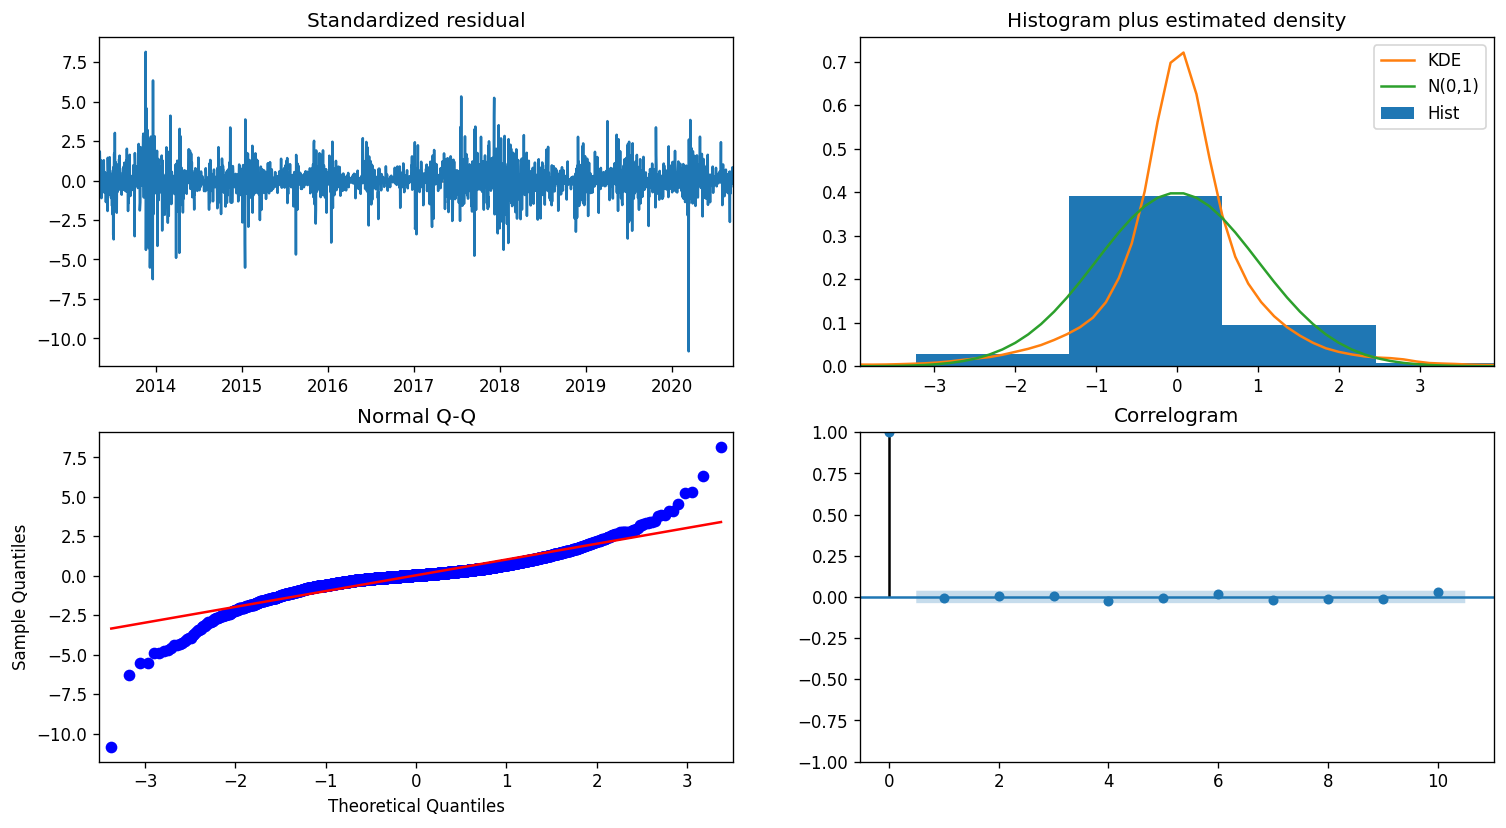

In [ ]:
fitted.plot_diagnostics(figsize=(15,8))
plt.show()

#### Kiểm tra với dữ liệu tập test

Vì trước đó nhóm thực hiện huấn luyện với dữ liệu log của giá đồng tiền, nên phần này nhóm tiến hành chuyển ngược dữ liệu dạng log về dữ liệu giá như ban đầu.

In [ ]:
# Values to test against the test set
fc   = fitted.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

train_origin = np.exp(train)
test_origin  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = fitted.get_prediction(start=pd.to_datetime('2014'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))

Biểu đồ dự đoán giá BTC

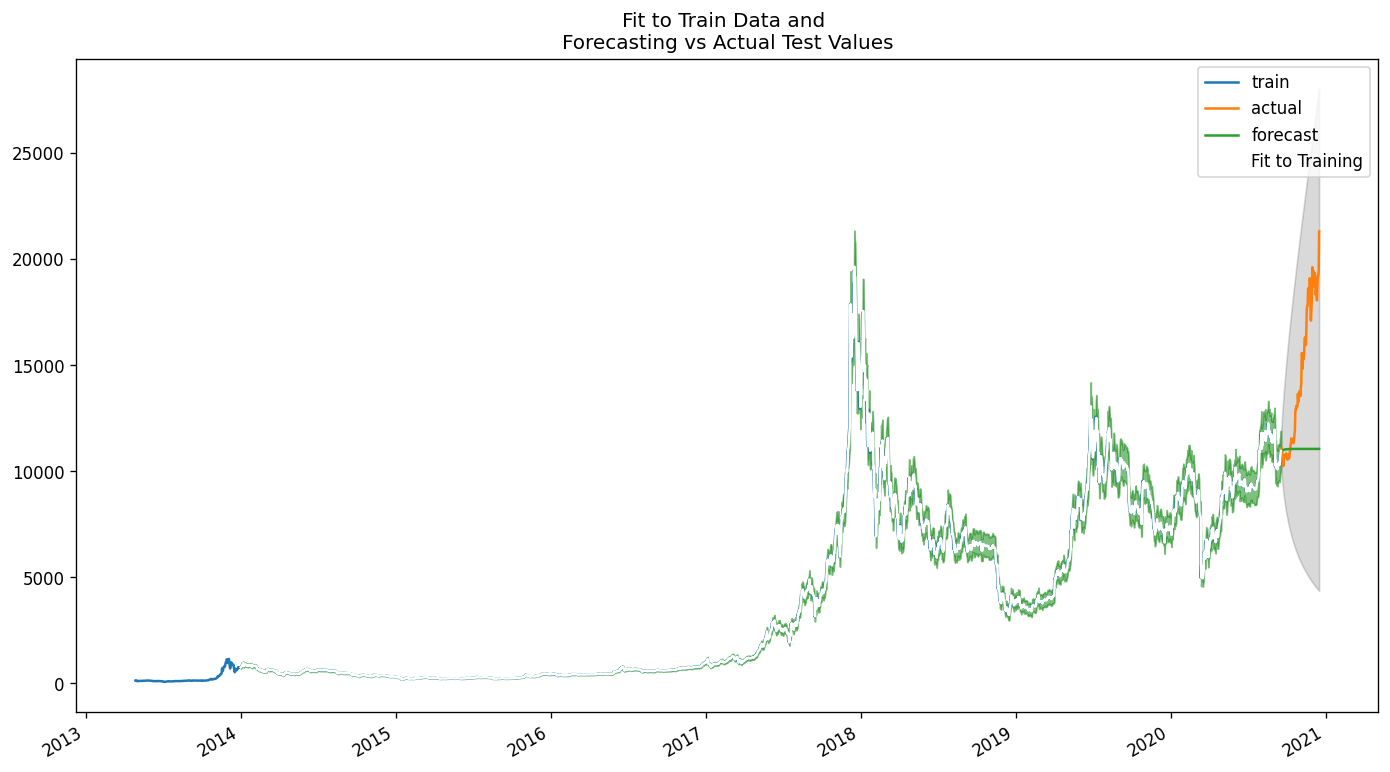

In [ ]:
plt.rcParams.update({'figure.figsize': (14, 8)})

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(train_origin, label='train')
plt.plot(test_origin, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.show()

Phóng to giai đoạn năm 2020

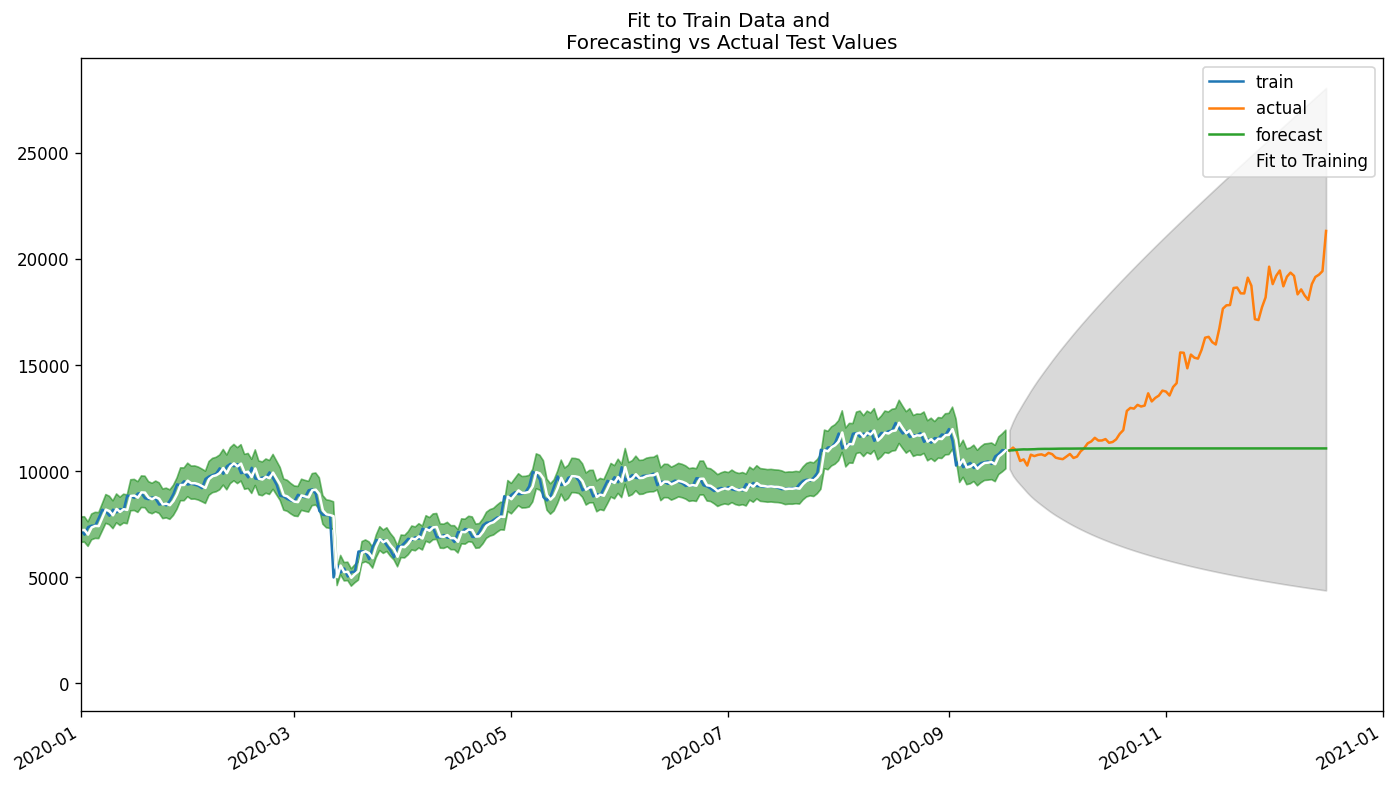

In [ ]:
plt.rcParams.update({'figure.figsize': (14, 8)})

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(train_origin, label='train')
plt.plot(test_origin, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

plt.xlim(['2020-01', '2021-01'])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.show()

#### Đánh giá độ lỗi

Nhóm đánh giá độ lỗi của mô hình bằng RMSE

In [ ]:
# Calculating our errors
rmse = np.sqrt(((pred - train_origin) ** 2).mean())

print("RMSE: ", rmse)

RMSE:  270.0173475014435


Ngoài ARIMA, nhóm cũng tiến hành thử nghiệm với mô hình Facebook Prophet và tiến hành so sánh nhằm chọn ra mô hình tốt hơn.

### Facebook Prophet

Facebook Prophet là mô hình dùng trong việc phân tích và dự đoán dữ liệu time-series dựa trên mô hình Addictive. Facebook Prophet có khả năng xử lý dữ liệu nhiễu và ngoại lai

#### Chuẩn bị dữ liệu

Vì FB Prophet cần dữ liệu theo đúng format yêu cầu, ta tiến hành tiền xử lý.

In [ ]:
prophet_df = pd.DataFrame(btc_df["close"])
prophet_df.reset_index(inplace=True)
prophet_df.columns = ["ds", "y"]
prophet_df

,ds,y
0,2013-04-28,134.21
1,2013-04-29,144.54
2,2013-04-30,139.00
3,2013-05-01,116.99
4,2013-05-02,105.21
...,...,...
2785,2020-12-12,18803.66
2786,2020-12-13,19142.38
2787,2020-12-14,19246.64
2788,2020-12-15,19417.08


#### Huấn luyện và đánh giá mô hình

In [ ]:
prophet = Prophet(interval_width=0.95)
prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=15, freq='D')
future.tail()

,ds
2800,2020-12-27
2801,2020-12-28
2802,2020-12-29
2803,2020-12-30
2804,2020-12-31


In [ ]:
forecast = prophet.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2800,2020-12-27,12742.785947,10787.070986,15796.959239,12726.064449,12763.541329,528.053273,528.053273,528.053273,-8.733250,-8.733250,-8.733250,536.786523,536.786523,536.786523,0.0,0.0,0.0,13270.839220
2801,2020-12-28,12752.764650,10694.386080,15782.818009,12730.796380,12775.919048,511.133327,511.133327,511.133327,12.800374,12.800374,12.800374,498.332953,498.332953,498.332953,0.0,0.0,0.0,13263.897977
2802,2020-12-29,12762.743353,10565.437434,15723.168912,12733.660038,12789.317466,469.681879,469.681879,469.681879,5.793039,5.793039,5.793039,463.888840,463.888840,463.888840,0.0,0.0,0.0,13232.425232
2803,2020-12-30,12772.722056,10489.653683,15859.315207,12737.613474,12805.508673,447.072117,447.072117,447.072117,13.436878,13.436878,13.436878,433.635239,433.635239,433.635239,0.0,0.0,0.0,13219.794173
2804,2020-12-31,12782.700759,10577.991843,15664.663708,12740.478353,12823.452852,391.575098,391.575098,391.575098,-16.050816,-16.050816,-16.050816,407.625914,407.625914,407.625914,0.0,0.0,0.0,13174.275857


In [ ]:
forecast.yhat[:-15]
btc_df.close

date
2013-04-28      134.21
2013-04-29      144.54
2013-04-30      139.00
2013-05-01      116.99
2013-05-02      105.21
                ...   
2020-12-12    18803.66
2020-12-13    19142.38
2020-12-14    19246.64
2020-12-15    19417.08
2020-12-16    21310.60
Name: close, Length: 2790, dtype: float64

#### Đánh giá độ lỗi của mô hình

In [ ]:
# Calculating our errors
rmse = np.sqrt(((forecast.yhat.values[:-15] - btc_df.close.values) ** 2).mean())

print("RMSE: ", rmse)

RMSE:  1343.6135841791847


### Sử dụng mô hình để dự đoán giá BTC trong tương lai

Với kết quả thu được ở trên, nhóm quyết định lựa chọn mô hình ARIMA với tham số (4,1,4).

Sau khi chọn lựa được mô hình, nhóm muốn tiến hành thử việc dự đoán giá trị BTC trong 15 ngày cuối cùng của năm 2020. Trong trường hợp này, mô hình sẽ được huấn luyện với toàn bộ tập dữ liệu.

In [ ]:
model = SARIMAX(btc_log_df, 
                order=best_param,
                freq='D',
                enforce_stationarity=False, 
                enforce_invertibility=False)
fitted = model.fit(disp=-1)

Sau khi huấn luyện xong, nhóm sẽ cho mô hình dự đoán giá BTC trong vòng 15 ngày.

In [ ]:
# Getting the forecast of future values
future = fitted.get_forecast(steps=15)

# Transforming values back
future_price = np.exp(future.predicted_mean)

# Confidence interval for forecasted values
future_conf = np.exp(future.conf_int())

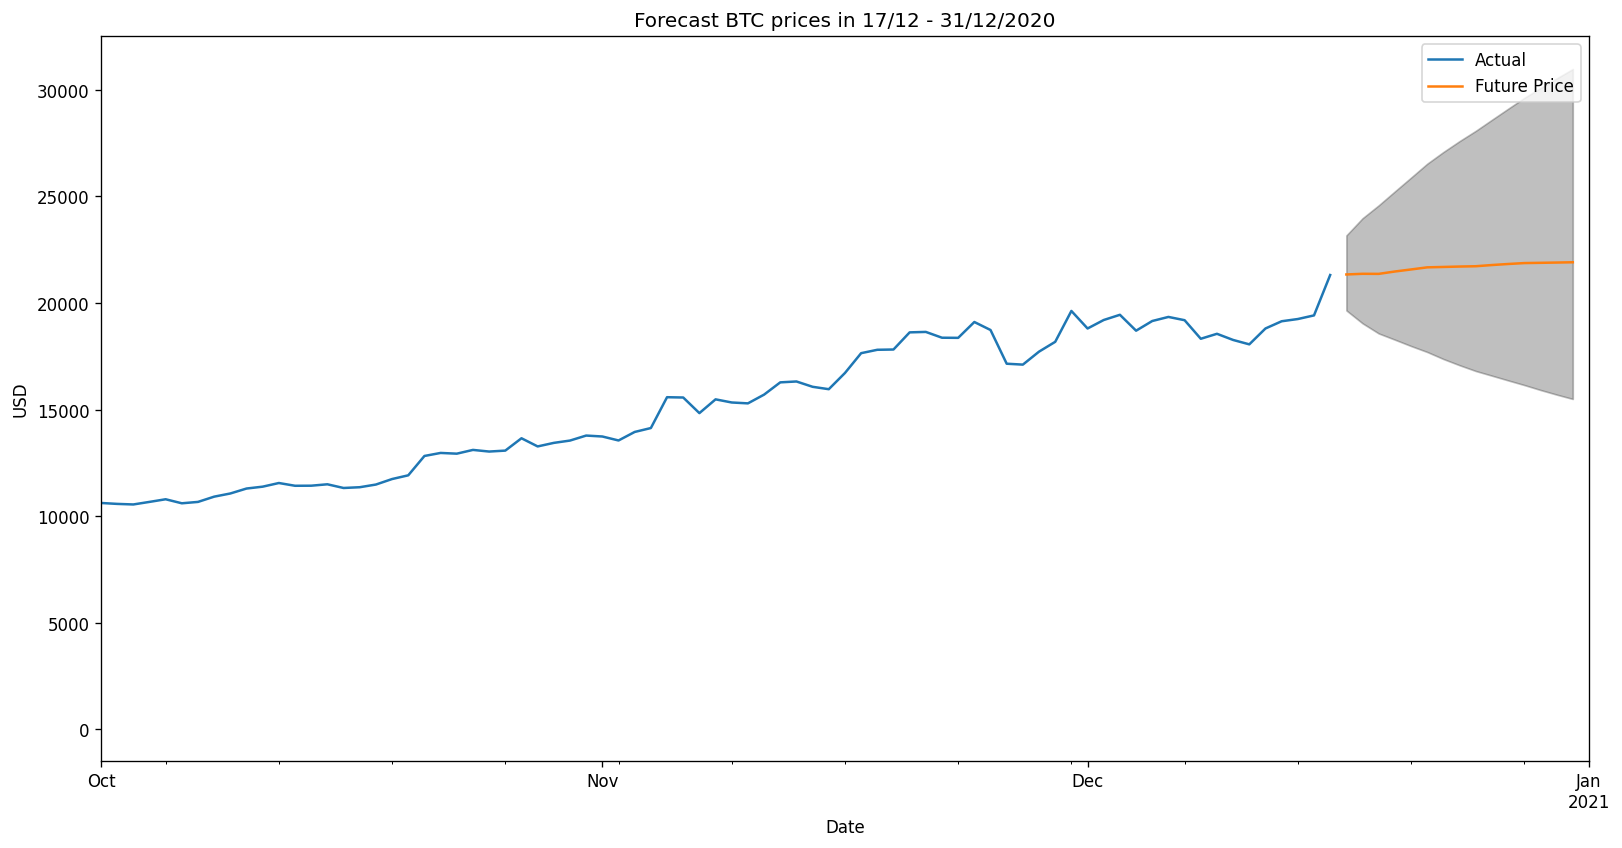

In [ ]:
ax = np.exp(btc_log_df.close).plot(label='Actual', figsize=(16,8))

# Plottting the forecast
future_price.plot(ax=ax, label='Future Price')

# Shading in the confidence interval
ax.fill_between(future_conf.index,
                future_conf.iloc[:, 0],
                future_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.set_xlim(['2020-10', '2021-01'])

plt.title('Forecast BTC prices in 17/12 - 31/12/2020')
plt.legend()
plt.show()

Mô hình dự đoán đồng tiền BTC sẽ tăng nhẹ về giá trị trong những ngày cuối cùng của năm 2020, trong khi trên thực tế nó đang tăng phi mã và đã cán mốc 28000 USD. Nhìn chung thì mô hình dự đoán đúng việc đồng BTC sẽ tiếp tục phát triển, tuy nhiên giá trị cụ thể chỉ mang tính tham khảo và chúng ta không nên sử dụng kết quả này để tiến hành đầu tư.

## Kết luận

Từ kết quả thu được, nhóm rút ra kết luận:
 - Số lượng đồng tiền ảo trên thị trường ngày càng tăng theo thời gian, chứng tỏ sự phát triển ngày càng lớn của thị truờng tiền điện tử.
 - Đồng Bitcoin (BTC) vẫn đang là đồng tiền phổ biến nhất, có giá trị và vốn hoá thị trường dẫn đầu so với các đồng tiền còn lại.
 - Đồng BTC nói riêng, thị trường tiền điện tử nói chung vẫn đang có xu hướng tiếp tục phát triển mạnh mẽ. (với sự phát triển của công nghệ và ảnh hưởng của dịch bệnh đang diễn ra trên khắp thế giới.